In [32]:
# !python -m pip install --upgrade pip

In [35]:
# !pip3 install torch

In [36]:
# !pip3 install torchvision

In [3]:
# !pip3 install numpy

In [38]:
# !pip install split-folders

In [1]:
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


In [5]:
import copy
import os
import time

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import cv2
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torchvision.models import ResNet18_Weights,ResNet34_Weights 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
main_folder = "ver_3-bg-mix"


# Preprocessing Data



In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.device_count()
torch.cuda.get_device_name()


'NVIDIA GeForce RTX 3050 Laptop GPU'

## Split Training and Testing Folders

In [3]:
main_folder = "ver_3-bg-mix"

In [36]:
import splitfolders

splitfolders.ratio(".\\data\\"+main_folder, output="./data/Output/"+main_folder+"/",
     seed=5123, ratio=(.8, .2), group_prefix=None, move=False) # default values

In [38]:
# os.remove('./data/Output/'+main_folder+'/Training')
# os.remove('./data/Output/'+main_folder+'/Testing')
os.rename('./data/Output/'+main_folder+'/train','./data/Output/'+main_folder+'/Training')
os.rename('./data/Output/'+main_folder+'/val','./data/Output/'+main_folder+'/Testing')

In [42]:
data_transforms = {

    'Training' : transforms.Compose([
        # transforms.RandomResizedCrop(219),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation((1,10)),
        transforms.Resize((100,100)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'Testing': transforms.Compose([
        # transforms.Resize(24),
        # transforms.CenterCrop(24),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])

    ])
}
data_dir = './data/Output/'+main_folder

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4,pin_memory=True) for x in ['Training', 'Testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

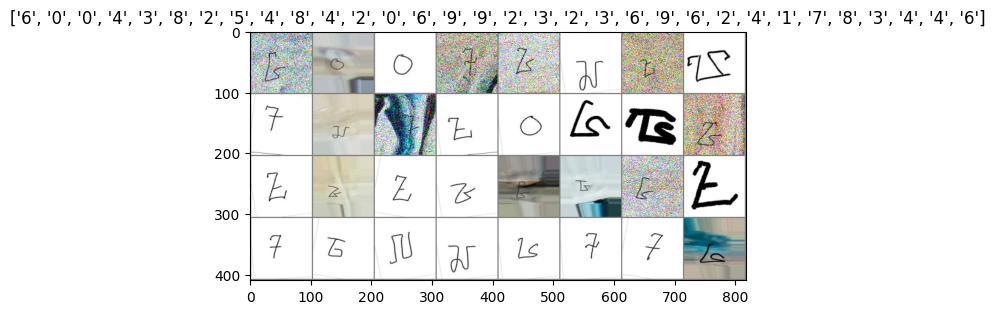

In [41]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Training']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training Model

In [43]:
def train_model(model, criterion, optimizer, scheduler, checkpoint, num_epochs=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_acc_array = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Testing']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad(set_to_none=True)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Training'):
                    # logits, outputs = model(inputs)
                    outputs = model(inputs)

                    # print(logits)
                    # print(outputs)
                    _, preds = torch.max(outputs, 1)
                    # print(preds.shape)
                    # print(inputs.shape)
                    # print(outputs.shape)
                    # print(outputs)
                    # print(labels.shape)
                    # print(labels)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Training':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            loss_acc_array.append('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Testing' and epoch_acc > best_acc:
                
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), './'+ checkpoint +'.pt')
                best_acc = epoch_acc
                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,loss_acc_array

## Premade Model

In [44]:
model_18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

In [12]:
model_34 = models.resnet34(weights=ResNet34_Weights.DEFAULT)

## Training Model

In [45]:
def main(model, PATH, checkpoint):
    num_ftrs = model.fc.in_features
    # # Here the size of each output sample is set to 2.
    # # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model.fc = nn.Linear(num_ftrs, len(class_names))
    model = model.to(device)

    criterion = nn.NLLLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    model,loss_acc_arr = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, checkpoint, num_epochs=10)

    print("\nSaving the model...")
    torch.save(model, PATH)
    print("\nModel Saved...")
    return model

In [46]:
os.remove('./model_18_'+main_folder+'.pth')
os.remove('./model_18_checkpoint_'+main_folder+'.pt')

In [47]:

model_18 = main(model_18, './model_18_'+main_folder+'.pth','model_18_checkpoint_'+main_folder)

Epoch 0/9
----------
Training Loss: -36.2664 Acc: 0.8378
Testing Loss: -80.3901 Acc: 0.9434

Epoch 1/9
----------
Training Loss: -118.3516 Acc: 0.9601
Testing Loss: -175.5149 Acc: 0.8510

Epoch 2/9
----------
Training Loss: -251.9562 Acc: 0.9781
Testing Loss: -340.7471 Acc: 0.9517

Epoch 3/9
----------
Training Loss: -446.6677 Acc: 0.9743
Testing Loss: -592.0301 Acc: 0.9490

Epoch 4/9
----------
Training Loss: -704.6538 Acc: 0.9833
Testing Loss: -834.3839 Acc: 0.9448

Epoch 5/9
----------
Training Loss: -1014.0092 Acc: 0.9892
Testing Loss: -1221.0896 Acc: 0.9600

Epoch 6/9
----------
Training Loss: -1374.6300 Acc: 0.9938
Testing Loss: -1571.2134 Acc: 0.9752

Epoch 7/9
----------
Training Loss: -1597.0885 Acc: 0.9986
Testing Loss: -1632.4252 Acc: 0.9766

Epoch 8/9
----------
Training Loss: -1636.7641 Acc: 0.9990
Testing Loss: -1665.2957 Acc: 0.9779

Epoch 9/9
----------
Training Loss: -1673.3782 Acc: 0.9993
Testing Loss: -1705.9147 Acc: 0.9779

Training complete in 2m 1s
Best val Acc: 0

In [13]:
model_34 = main(model_34, './model_34_'+main_folder+'.pth','model_34_checkpoint_'+main_folder)

Epoch 0/9
----------
Training Loss: -141.6852 Acc: 0.9405
Testing Loss: -161.1044 Acc: 0.3625

Epoch 1/9
----------
Training Loss: -647.5236 Acc: 0.9862
Testing Loss: -509.5964 Acc: 0.3006

Epoch 2/9
----------
Training Loss: -1542.3422 Acc: 0.9909
Testing Loss: -1072.1677 Acc: 0.3324

Epoch 3/9
----------
Training Loss: -2852.6923 Acc: 0.9950
Testing Loss: -1957.9932 Acc: 0.2938

Epoch 4/9
----------
Training Loss: -4577.7562 Acc: 1.0000
Testing Loss: -3046.9616 Acc: 0.2619

Epoch 5/9
----------
Training Loss: -6698.4171 Acc: 1.0000
Testing Loss: -4341.2370 Acc: 0.2415

Epoch 6/9
----------
Training Loss: -9192.2275 Acc: 1.0000
Testing Loss: -5991.9897 Acc: 0.2932

Epoch 7/9
----------
Training Loss: -10701.2082 Acc: 1.0000
Testing Loss: -6096.2745 Acc: 0.3409

Epoch 8/9
----------
Training Loss: -10959.2787 Acc: 1.0000
Testing Loss: -6110.1521 Acc: 0.2369

Epoch 9/9
----------
Training Loss: -11202.8321 Acc: 1.0000
Testing Loss: -6381.9794 Acc: 0.3148

Training complete in 6m 2s
Best

# Model Summary

In [14]:
from torchsummary import summary

summary(model_18,(3,100,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           9,408
       BatchNorm2d-2           [-1, 64, 50, 50]             128
              ReLU-3           [-1, 64, 50, 50]               0
         MaxPool2d-4           [-1, 64, 25, 25]               0
            Conv2d-5           [-1, 64, 25, 25]          36,864
       BatchNorm2d-6           [-1, 64, 25, 25]             128
              ReLU-7           [-1, 64, 25, 25]               0
            Conv2d-8           [-1, 64, 25, 25]          36,864
       BatchNorm2d-9           [-1, 64, 25, 25]             128
             ReLU-10           [-1, 64, 25, 25]               0
       BasicBlock-11           [-1, 64, 25, 25]               0
           Conv2d-12           [-1, 64, 25, 25]          36,864
      BatchNorm2d-13           [-1, 64, 25, 25]             128
             ReLU-14           [-1, 64,

In [15]:
from torchsummary import summary

summary(model_34,(3,100,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           9,408
       BatchNorm2d-2           [-1, 64, 50, 50]             128
              ReLU-3           [-1, 64, 50, 50]               0
         MaxPool2d-4           [-1, 64, 25, 25]               0
            Conv2d-5           [-1, 64, 25, 25]          36,864
       BatchNorm2d-6           [-1, 64, 25, 25]             128
              ReLU-7           [-1, 64, 25, 25]               0
            Conv2d-8           [-1, 64, 25, 25]          36,864
       BatchNorm2d-9           [-1, 64, 25, 25]             128
             ReLU-10           [-1, 64, 25, 25]               0
       BasicBlock-11           [-1, 64, 25, 25]               0
           Conv2d-12           [-1, 64, 25, 25]          36,864
      BatchNorm2d-13           [-1, 64, 25, 25]             128
             ReLU-14           [-1, 64,

# Testing with New Data

In [227]:
def testing(data_path, model_pth):
    transform = transforms.Compose([
            # transforms.RandomResizedCrop(219),
            # transforms.RandomHorizontalFlip(),
            # transforms.Resize(28),

            transforms.ToTensor(),
            # transforms.Normalize([0.485], [0.229])
            # transforms.Normalize([0.5], [0.5])
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    # img = Image.open('.\Ka28x28.jpg').convert('RGB')
    img = Image.open(data_path).convert('RGB').resize((100,100))
    plt.imshow(img)

    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    batch_t = batch_t.to(device)

    model_ft = torch.load(model_pth)
    model_ft.eval()
    out = model_ft(batch_t)
    values, preds = torch.max(out, 1)
    # print(img)
    # print(out)
    print(preds)
    # print(class_names[preds[0]])
    plt.title(model_pth)
    plt.xlabel('Prediction : '+ class_names[preds[0]])
    # logits, out = model_ft(batch_t)
    sm = torch.nn.Softmax(dim=1)
    top_out = sm(out)
    top_prob, top_label = torch.topk(top_out,3)
    print(top_prob, top_label)
    print("top_prob : "+ str(top_prob[0][0].cpu().detach().numpy()), "top_label :"+ str(top_label[0][0].cpu().detach().numpy()))
    return class_names[preds[0]]

tensor([2], device='cuda:0')
tensor([[1., 0., 0.]], device='cuda:0', grad_fn=<TopkBackward0>) tensor([[2, 1, 0]], device='cuda:0')
top_prob : 1.0 top_label :2


'2'

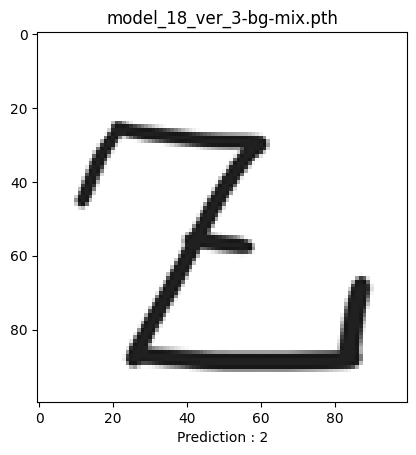

In [228]:
testing('.\\data\\test\\angka\\2.jpg','model_18_'+main_folder+'.pth')

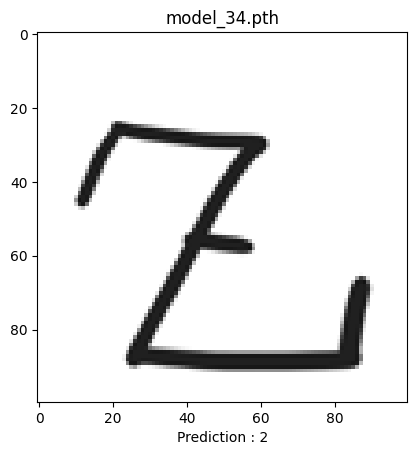

In [27]:
testing('.\\data\\test\\angka\\2.jpg','model_34.pth')

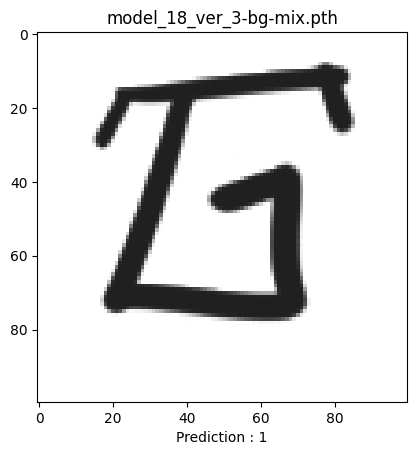

In [50]:
testing('.\\data\\test\\angka\\1.jpg','model_18_'+main_folder+'.pth')

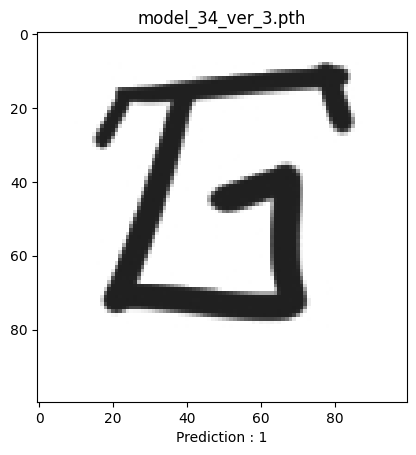

In [20]:
testing('.\\data\\test\\angka\\1.jpg','model_34_ver_3.pth')


# Character Segmentation

In [7]:
from sklearn.cluster import KMeans
from collections import Counter
import cv2 #for resizing image

def get_dominant_color(image, k=4, image_processing_size = None):
    """
    takes an image as input
    returns the dominant color of the image as a list
    
    dominant color is found by running k means on the 
    pixels & returning the centroid of the largest cluster

    processing time is sped up by working with a smaller image; 
    this resizing can be done with the image_processing_size param 
    which takes a tuple of image dims as input

    >>> get_dominant_color(my_image, k=4, image_processing_size = (25, 25))
    [56.2423442, 34.0834233, 70.1234123]
    """
    #resize image if new dims provided
    if image_processing_size is not None:
        image = cv2.resize(image, image_processing_size, 
                            interpolation = cv2.INTER_AREA)
    
    #reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    #cluster and assign labels to the pixels 
    clt = KMeans(n_clusters = k)
    labels = clt.fit_predict(image)

    #count labels to find most popular
    label_counts = Counter(labels)

    #subset out most popular centroid
    dominant_color = clt.cluster_centers_[label_counts.most_common(1)[0][0]]

    return list(dominant_color)


In [9]:
def predict(data_path, model_pth):
    transform = transforms.Compose([
            # transforms.RandomResizedCrop(219),
            # transforms.RandomHorizontalFlip(),
            # transforms.Resize(28),

            transforms.ToTensor(),
            # transforms.Normalize([0.485], [0.229])
            # transforms.Normalize([0.5], [0.5])
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    # img = Image.open('.\Ka28x28.jpg').convert('RGB')
    img = Image.fromarray(data_path).convert('RGB').resize((100,100))

    plt.imshow(img)

    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    batch_t = batch_t.to(device)

    model_ft = torch.load(model_pth)
    model_ft.eval()
    out = model_ft(batch_t)
    values, preds = torch.max(out, 1)
    # print(out)
    # print(preds)
    # print(class_names[preds[0]])
    plt.title(model_pth)
    plt.xlabel('Prediction : '+ class_names[preds[0]])
    # logits, out = model_ft(batch_t)

    sm = torch.nn.Softmax(dim=1)
    top_out = sm(out)
    top_prob, top_label = torch.topk(top_out,3)
    # print(top_prob, top_label)
    # print("top_prob : "+ str(top_prob[0][0].cpu().detach().numpy()), "top_label :"+ str(top_label[0][0].cpu().detach().numpy()))
    prob = str(top_prob[0][0].cpu().detach().numpy()*100)
    label = "top_label :"+ str(top_label[0][0].cpu().detach().numpy())
    # return class_names[preds[0]]+" "+prob + "%"
    return (class_names[preds[0]], prob)

0 94 185 205 199
1 157 0 92 122


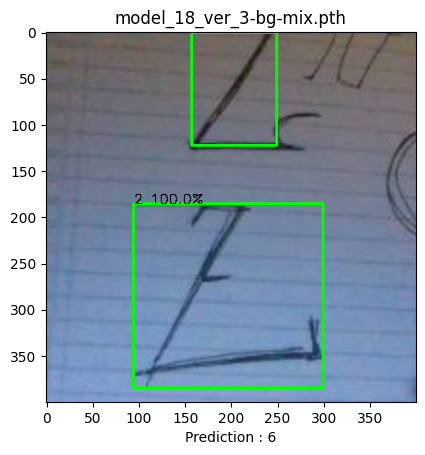

In [10]:
image = cv2.imread(".\\data\\test\\angka\\2_camera.jpg")
# image = cv2.imread(".\\data\\test\\angka\\all.png")

image = cv2.resize(image, (400,400))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
canny = cv2.Canny(blur,0,200)

# threshold the image
# ret,th3 = cv2.threshold(gray ,200,255,cv2.THRESH_BINARY)
# th3 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,2)
# th3 = cv2.adaptiveThreshold(canny,200,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,11)
ret3,th3 = cv2.threshold(canny,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


# dilate the white portions
dilate = cv2.dilate(th3, None, iterations=1)
erode = cv2.erode(dilate,None,iterations=1)
# find contours in the image
cnts = cv2.findContours(erode.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
# cnts = cnts[0] if imutils.is_cv2() else cnts[1]

orig = image.copy()
i = 0
font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 0.5
fontColor              = (0,0,0)
thickness              = 1
lineType               = 1


for cnt in cnts:
    # Check the area of contour, if it is very small ignore it
    if(cv2.contourArea(cnt) < 100):
        # print(cv2.contourArea(cnt))
        continue

    # Filtered countours are detected
    x,y,w,h = cv2.boundingRect(cnt)

    # Taking ROI of the cotour
    roi = image[y:y+h, x:x+w]
    print(i, x,y,w,h)
    # Mark them on the image if you want
    value = get_dominant_color(roi, k=4, image_processing_size = (100,100))
    # roi = cv2.copyMakeBorder(roi, 20, 20, 20, 20, cv2.BORDER_CONSTANT, None, value)
    roi = cv2.copyMakeBorder(roi, 20, 20, 20, 20, cv2.BORDER_CONSTANT, None, [255,255,255])

    prediction = str(predict(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB),'model_18_'+main_folder+'.pth'))
    cv2.rectangle(orig,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.putText(orig,prediction, 
        # (x+int(w/2),y+int(h/2)),
        (x,y),  
        font, 
        fontScale,
        fontColor,
        thickness,
        lineType)

    # cv2.imwrite("roi" + str(i) + ".png", roi)
    i = i + 1 

images = [  blur,th3,erode,orig]
# for i in range(3):
#     plt.subplot(4,3,(i+1)),plt.imshow(images[i])
#     # plt.title(titles[i])
#     # plt.xticks([]),plt.yticks([])

# plt.subplot(4,3,(4,12)),plt.imshow(images[3])
plt.imshow(images[3])
plt.show()


# CNN for Bounding Boxes